# Trabalho 3
Descrição do trabalho:

http://webserver2.tecgraf.puc-rio.br/~mgattass/visao/trb/T3.html

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

### Usando o Numpy (OLD)

<!-- #### Funções de ativação -->

In [2]:
# def tanh(x):
#   return np.tanh(x)

# def tanh_prime(x):
#   return 1-np.tanh(x)**2

In [3]:
# def sigmoid(x):
#   return 1/(1+np.exp(-x))

# def sigmoid_prime(x):
#   s = 1/(1+np.exp(-x))
#   ds = s*(1-s)
#   return ds

In [4]:
# def relu(x):
#   return np.maximum(0,x)

# def relu_prime(x):
#   return (x>0).astype(x.dtype)

<!-- #### Função loss -->

In [5]:
# # loss function and its derivative
# def mse(y_true, y_pred):
#   return np.mean(np.power(y_true-y_pred, 2))

In [6]:
# def mse_prime(y_true, y_pred):
#   grad_output = 2*(y_pred-y_true)/y_true.size
#   return grad_output

<!-- #### class Layer -->

In [7]:
# # Base class
# class Layer:
#   def __init__(self):
#     self.input = None
#     self.output = None

#   # computes the output Y of a layer for a given input X
#   def forward(self, input):
#     raise NotImplementedError

#   # computes dE/dX for a given dE/dY (and update parameters, if any)
#   def backward(self, grad_output, learning_rate):
#     raise NotImplementedError

<!-- #### class FCLayer(Layer) -->

In [8]:
# # inherit from base class Layer
# class FCLayer(Layer):
#   # input_size = number of input neurons
#   # output_size = number of output neurons
#   def __init__(self, input_size, output_size):
#     self.weights = 2*np.random.rand(input_size, output_size) - 1.0
#     self.bias = 2*np.random.rand(1, output_size) - 1.0

#   # returns output for a given input
#   def forward(self, input):
#     self.input = input
#     self.output = np.dot(input, self.weights) + self.bias
#     return self.output

#   # computes dE/dW, dE/dB for a given grad_output=dE/dY.
#   # returns grad_input=dE/dX.
#   # ajusta os pesos e bias em função da regra do
#   # gradiente descendente
#   def backward(self, grad_output, learning_rate):
#     grad_input = np.dot(grad_output, self.weights.T)
#     grad_weights = np.dot(self.input.T, grad_output)
#     grad_bias = grad_output

#     # update parameters
#     self.weights -= learning_rate * grad_weights
#     # self.bias -= learning_rate * grad_bias
#     self.bias = self.bias - learning_rate * grad_bias
#     return grad_input

<!-- #### class ActivationLayer(Layer) -->

In [9]:
# class ActivationLayer(Layer):
#   def __init__(self, activation, activation_prime):
#     self.activation = activation
#     self.activation_prime = activation_prime

#   # returns the activated input
#   def forward(self, input):
#     self.input = input
#     self.output = self.activation(self.input)
#     return self.output

#   # Returns grad_input=dE/dX given grad_output=dE/dY.
#   # learning_rate is not used because there is no "learnable" parameters.
#   def backward(self, grad_output, learning_rate):
#     return self.activation_prime(self.input) * grad_output

<!-- #### class Network -->

In [10]:
# class Network:
#   def __init__(self):
#     self.layers = []
#     self.loss = None
#     self.loss_prime = None

#   # add layer to network
#   def add(self, layer):
#     self.layers.append(layer)

#   # set loss to use
#   def use(self, loss, loss_prime):
#     self.loss = loss
#     self.loss_prime = loss_prime

#   # predict output for given input
#   def predict(self, input_data):
#     # sample dimension first
#     # n_samples = len(input_data)
#     n_samples = input_data.shape[0]#daniel
#     result = []
    
#     #   # run network over all n_samples
#     # for i in range(n_samples):
    
#     #   # forward propagation
#     #   output = input_data[i]
#     #   for layer in self.layers:
#     #     output = layer.forward(output)        
#     #   result.append(output)

#     #daniel
#     for j in range(n_samples):

#       # forward propagation
#       output = input_data[j]
#       for layer in self.layers:
#         output = layer.forward(output)
        
#       result.append(output)

#     return result
#     # return result[-1]

#   # train the network
#   def fit(self, x_train, y_train, epochs, learning_rate):
#     n_samples = x_train.shape[0]
    
#     # training loop
#     for i in range(epochs):
#       err = 0
#       for j in range(n_samples):

#         # forward propagation
#         output = x_train[j]
#         for layer in self.layers:
#           output = layer.forward(output)

#         # compute loss (for display purpose only)
#         err += self.loss(y_train[j], output)

#         # backward propagation
#         grad_out = self.loss_prime(y_train[j], output)
#         for layer in reversed(self.layers):
#           grad_out = layer.backward(grad_out, learning_rate)

#       if i % 500 == 0:
#         # calculate average error on all samples
#         err /= n_samples
#         print(f'epoch {i+1}/{epochs} error={err:.3f}')

<!-- #### Treinamento -->

In [11]:
# x_train = np.array( [1, 2, 3, 4, 5] )
# y_train = np.array( [2, 4, 6, 8, 10] )

In [12]:
# input_size = len(x_train)
# output_size = 5 # output_size = m = number of weights

# network = Network()
# network.add( FCLayer(input_size, output_size) )
# network.add( ActivationLayer(sigmoid, sigmoid_prime) )
# network.add( FCLayer(output_size, 1) ) #daniel
# # network.add( ActivationLayer(sigmoid, sigmoid_prime) ) #daniel

# network.use( mse, mse_prime )
# network.fit(x_train, 
#             y_train, 
#             epochs = 10000, 
#             learning_rate = 1e-3)

<!-- #### Predição -->

In [13]:
# x_test = np.array( [6, 7, 8, 9, 10] )
# y_test = np.array( [12, 14, 16, 18, 20] )

In [14]:
# results = network.predict( x_test )
# y_pred = results
# y_pred

### Usando o Numpy

#### Funções de erro

In [15]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

#### class Layer

In [16]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

#### Activation(Layer)

In [17]:
def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1 - np.tanh(x) ** 2

In [18]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_prime(x):
  s = 1/(1+np.exp(-x))
  ds = s*(1-s)
  return ds

In [19]:
def relu(x):
  return np.maximum(0,x)

def relu_prime(x):
  return (x>0).astype(x.dtype)

In [20]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

<!-- #### Tanh(Activation) -->

In [21]:
# class Tanh(Activation):
#     def __init__(self):
#         def tanh(x):
#             return np.tanh(x)

#         def tanh_prime(x):
#             return 1 - np.tanh(x) ** 2

#         super().__init__(tanh, tanh_prime)

# class Sigmoid(Activation):
#     def __init__(self):
#         def sigmoid(x):
#             return 1 / (1 + np.exp(-x))

#         def sigmoid_prime(x):
#             s = sigmoid(x)
#             return s * (1 - s)

#         super().__init__(sigmoid, sigmoid_prime)

# class Softmax(Layer):
#     def forward(self, input):
#         tmp = np.exp(input)
#         self.output = tmp / np.sum(tmp)
#         return self.output
    
#     def backward(self, output_gradient, learning_rate):
#         # This version is faster than the one presented in the video
#         n = np.size(self.output)
#         return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)
#         # Original formula:
#         # tmp = np.tile(self.output, n)
#         # return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)

#### class Dense(Layer)

In [22]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient 

#### def predict(...)

In [23]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

#### def train(...)

In [24]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            if e % 500 == 0:
                print(f"{e}/{epochs}, error={error:.3}")

#### Exemplo XOR

In [25]:
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(input_size = 2, 
          output_size = 3),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 3, 
          output_size = 1),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

train(
    network, 
    mse, 
    mse_prime, 
    X, 
    Y, 
    epochs=10000, 
    learning_rate=0.1)

0/10000, error=1.31
500/10000, error=0.185
1000/10000, error=0.18
1500/10000, error=0.000449
2000/10000, error=0.000205
2500/10000, error=0.000133
3000/10000, error=9.84e-05
3500/10000, error=7.8e-05
4000/10000, error=6.46e-05
4500/10000, error=5.51e-05
5000/10000, error=4.81e-05
5500/10000, error=4.26e-05
6000/10000, error=3.82e-05
6500/10000, error=3.46e-05
7000/10000, error=3.17e-05
7500/10000, error=2.92e-05
8000/10000, error=2.71e-05
8500/10000, error=2.52e-05
9000/10000, error=2.36e-05
9500/10000, error=2.22e-05


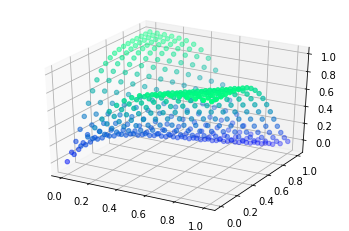

In [26]:
# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()